# CNN Applied to EEG Data


## Preparation and Loading Data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%pwd

'/content/drive/My Drive/ECE C147/project'

In [11]:
% cd 'drive/My Drive/ECE C147'
% cd 'project'
% ls


[Errno 2] No such file or directory: 'drive/My Drive/ECE C147'
/content/drive/My Drive/ECE C147/project
[Errno 2] No such file or directory: 'project'
/content/drive/My Drive/ECE C147/project
EEG_loading.ipynb  person_train_valid.npy  X_train_valid.npy  y_train_valid.npy
person_test.npy    X_test.npy              y_test.npy


In [12]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
import time

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [14]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769


print('y_train_valid', y_train_valid[:10])

# copy numpy data to tensor
X_train_valid_tensor = torch.from_numpy(X_train_valid).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_valid).float().long().to(device) # do not forget .long()
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().long().to(device)


# # convert int labels to one hot labels
# y_train_valid_tensor = nn.functional.one_hot(y_train_valid_tensor)
# print('y_train_valid_onehot', y_train_valid_tensor[:10])

y_train_valid [2 3 0 0 0 0 2 1 3 3]


In [15]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [82]:
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        return len(self.subset)

init_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)
# split train and val
lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
subset_train, subset_val = random_split(init_dataset, lengths) 

train_data = EEGDataset(
    subset_train, transform=None)

val_data = EEGDataset(
    subset_val, transform=None)

test_data=EEGDataset(test_dataset,transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, num_workers=0),
    'test':torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
}

## Model

In [83]:
class DeepConv(nn.Module):
  def __init__(self, in_channels, classes):
    super(DeepConv, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels, 25, (1, 10), stride=1)
    self.relu1=nn.ELU()
    self.bn1=nn.BatchNorm2d(num_features=25)
    self.conv2 = nn.Conv2d(25,25,(22,1),stride=1)
    self.relu2=nn.ELU()
    self.bn2=nn.BatchNorm1d(num_features=25)
    self.maxpool1 = nn.MaxPool1d(3, stride=3)

    self.conv3=nn.Conv1d(25,50,10,1)
    self.relu3=nn.ELU()
    self.bn3=nn.BatchNorm1d(num_features=50)
    self.maxpool2=nn.MaxPool1d(3,stride=3)

    self.conv4 = nn.Conv1d(50,100,10,1)
    self.relu4=nn.ELU()
    self.bn4=nn.BatchNorm1d(num_features=100)
    self.maxpool3=nn.MaxPool1d(3,stride=3)

    self.conv5=nn.Conv1d(100,200,10,1)
    self.relu5=nn.ELU()
    self.bn5=nn.BatchNorm1d(num_features=200)
    self.maxpool4=nn.MaxPool1d(3,stride=3)

    self.fc = nn.Linear(1400, classes)


  def forward(self, x):
    x = x.view(-1, 1, 22, 1000) # reshape x: (B, 22, 1000) -> (B, 1, 22, 1000), B,C,H,W
    x = self.conv1(x) # (B, 25, 22, 976)
    x=self.relu1(x)
    x=self.bn1(x)
    #print(x.shape)
    x=self.conv2(x) # B,25,1,976
    x = self.relu2(x)
    #print(x.shape)
    x=x.reshape(-1,25,991) 
    x=self.bn2(x)
    x=self.maxpool1(x)  #B,25,325

    x=self.conv3(x) #B,50,316
    x=self.relu3(x)
    x=self.bn3(x)
    x=self.maxpool2(x) # B,50,105

    x=self.conv4(x)#B,100,96
    x=self.relu4(x)
    x=self.bn4(x)
    x=self.maxpool3(x) #B,100,32

    x=self.conv5(x) #B,200,23
    x=self.relu5(x)
    x=self.bn5(x)
    x=self.maxpool4(x) #B,200,7

    x=x.reshape(-1,1400)
    x=self.fc(x)

    return x


In [84]:
def train_model(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later

            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))


        prefix = ''
        if phase == 'val':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

In [85]:
def test(model):
    dataloader = dataloaders['test']
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Train the Model

In [101]:
# define the hyperparamters
weight_decay = 0.15  # weight decay to alleviate overfiting

model = DeepConv(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = 1e-6, weight_decay=weight_decay)

model parameters amount 283304


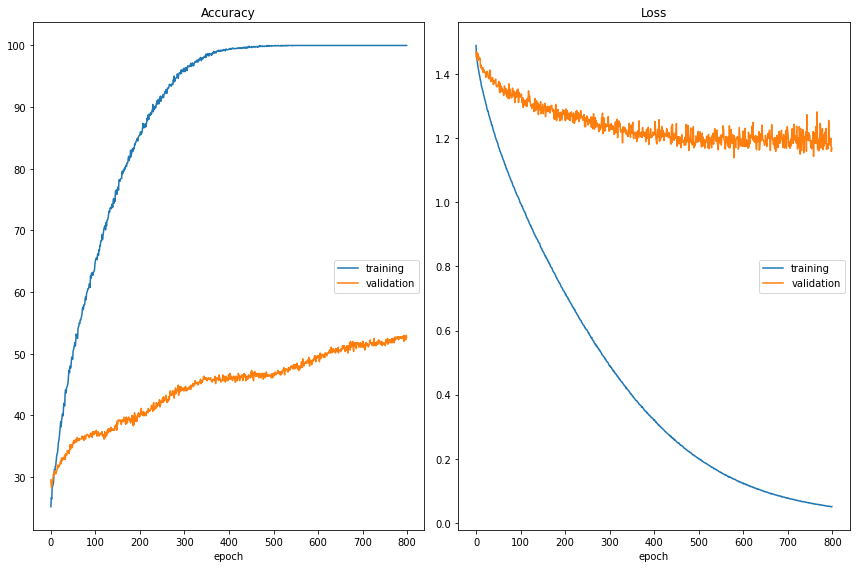

Accuracy
	training         	 (min:   25.177, max:  100.000, cur:  100.000)
	validation       	 (min:   28.369, max:   52.955, cur:   52.719)
Loss
	training         	 (min:    0.051, max:    1.488, cur:    0.051)
	validation       	 (min:    1.138, max:    1.468, cur:    1.169)


In [102]:
model=train_model(model, optimizer, num_epochs=800)

In [103]:
test(model)

Test Error: 
 Accuracy: 49.2%, Avg loss: 0.019476 

